In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

from unsloth import FastLanguageModel
import torch
max_seq_length = 1024 # Choose any! We auto support RoPE Scaling internally!
dtype = None          # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True   # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "Nhudang/DeepSeek-R1-Distill-Llama-8B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

2025-05-23 01:52:27.805847: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747965147.830240     185 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747965147.837744     185 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Pip install necessary package
%pip install --upgrade --quiet  neo4j
%pip install --upgrade --quiet  langchain-openai langchain-neo4j
%pip install --upgrade --quiet  tiktoken
%pip install langchain langchain-community python-dotenv --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
from langchain_community.document_loaders import TextLoader
from langchain_core.documents import Document
from langchain_neo4j import Neo4jVector
# from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import CharacterTextSplitter

In [ ]:
# from langchain.document_loaders import DirectoryLoader
# loader = DirectoryLoader(
#     "/kaggle/input/dataset/documents",
#     glob="**/*.txt",                     # Đọc tất cả file .txt kể cả trong thư mục con
#     loader_cls=TextLoader                # Sử dụng TextLoader cho mỗi file
# )

# documents = loader.load()
# text_splitter = CharacterTextSplitter(chunk_size=400, chunk_overlap=50)
# docs = text_splitter.split_documents(documents)

# # embeddings = OpenAIEmbeddings()

In [ ]:
print("the num of chunks:", len(docs))

In [4]:
# Neo4jVector requires the Neo4j database credentials

url = "neo4j+s://1fe0454c.databases.neo4j.io"
username = "neo4j"
password = "E8rUVyDPMhcSDq2_Vngae2rNsTgp7_qYfxvjwl9rN7g"

# You can also use environment variables instead of directly passing named parameters
# os.environ["NEO4J_URI"] = "bolt://localhost:7687"
# os.environ["NEO4J_USERNAME"] = "neo4j"
# os.environ["NEO4J_PASSWORD"] = "pleaseletmein"

In [10]:
from sentence_transformers import SentenceTransformer
from langchain.embeddings import HuggingFaceEmbeddings

In [11]:
# Khởi tạo embeddings từ HuggingFace
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


In [ ]:

# Kết nối và lưu vector vào Neo4j
db = Neo4jVector.from_documents(
    docs,                                  # Tài liệu đã chia nhỏ
    embeddings,                            # Embedding từ HuggingFace
    url=url,
    username=username,
    password=password
)

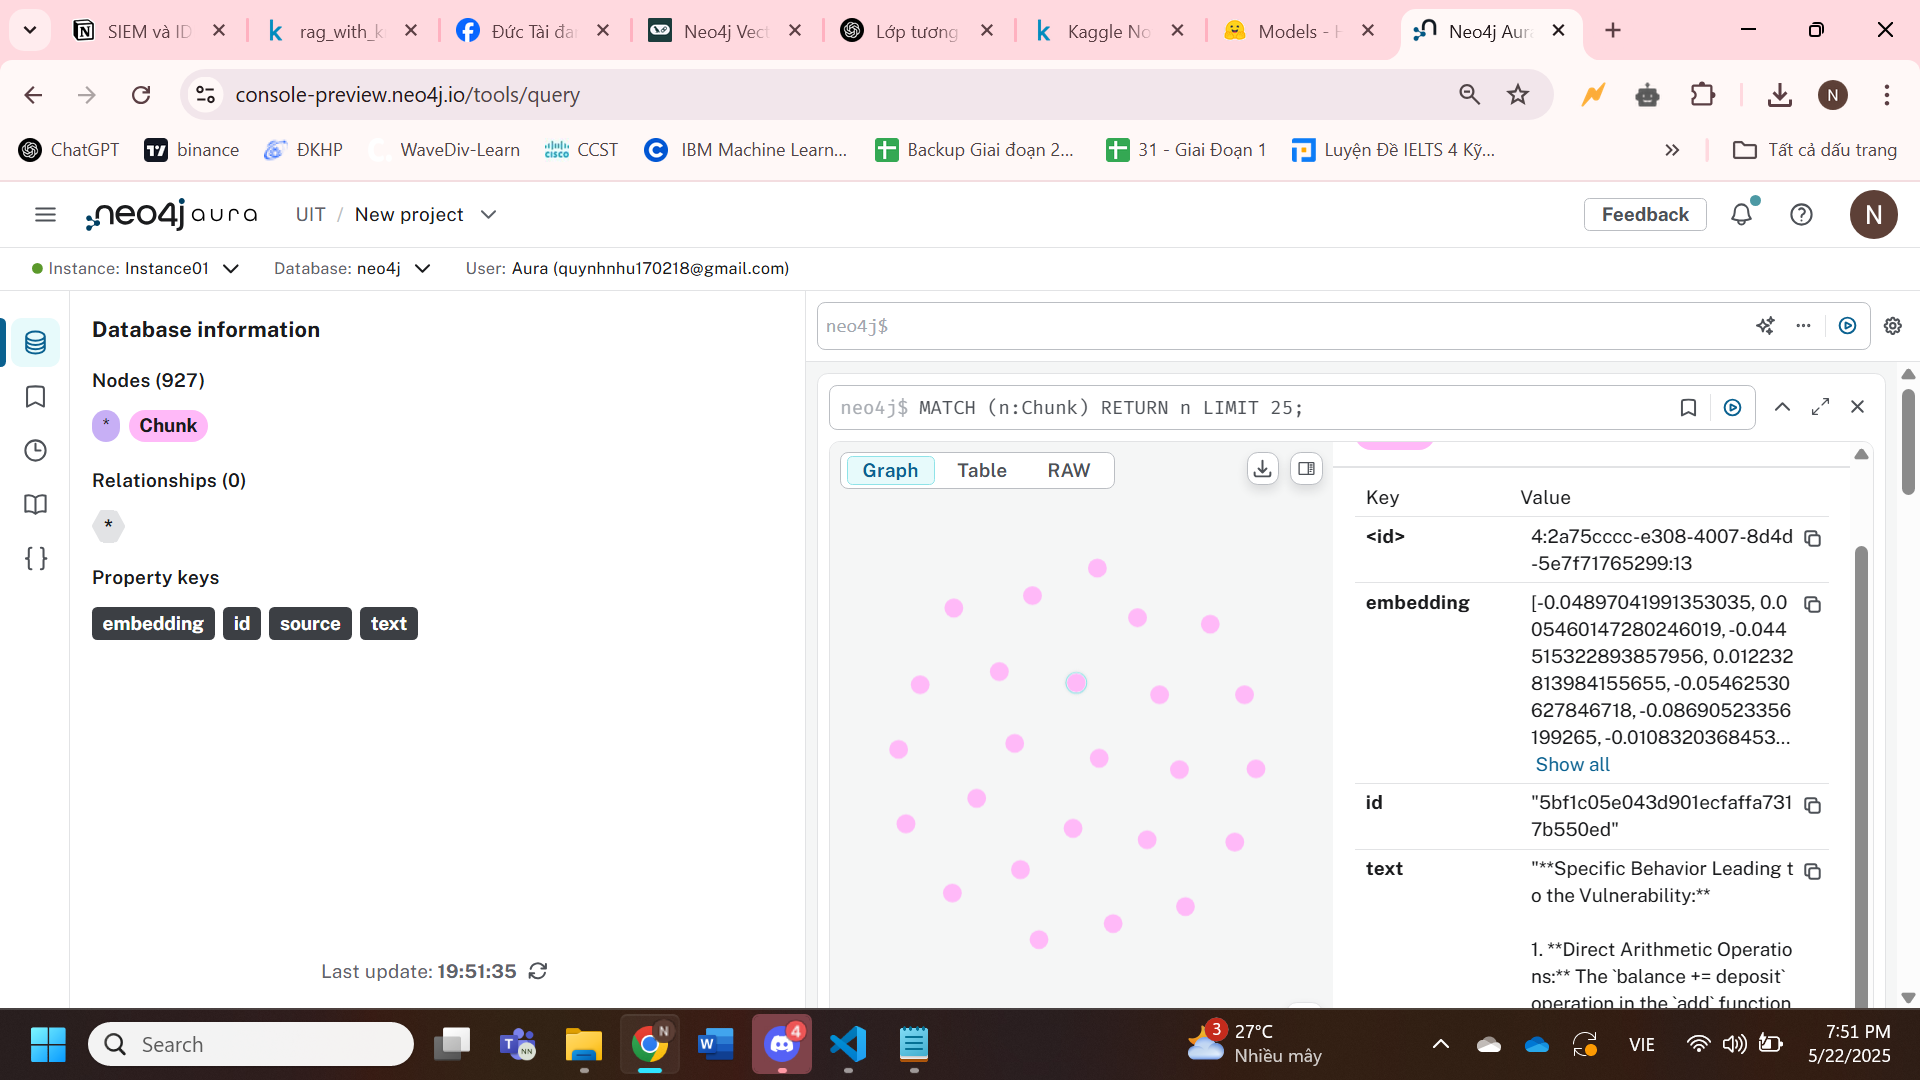

In [ ]:
query = "what are solutions for reentrancy"
docs_with_score = db.similarity_search_with_score(query, k=5)

In [ ]:
for doc, score in docs_with_score:
    print("-" * 80)
    print("Score: ", score)
    print(doc.page_content)
    print("-" * 80)

**giải thích**
 1. `for doc, score in docs_with_score:`

* `docs_with_score` là một **danh sách các tuple**, trong đó mỗi phần tử có dạng `(doc, score)`:

  * `doc`: là một đối tượng tài liệu (thường là `Document` trong LangChain), chứa nội dung văn bản và metadata.
  * `score`: là **điểm số liên quan đến mức độ phù hợp** của tài liệu với một truy vấn tìm kiếm (ví dụ, điểm cosine similarity khi tìm vector gần nhất).

---

 2. `print("-" * 80)`

* In ra 80 dấu `-` để phân cách giữa các tài liệu — mục đích là **cho dễ nhìn khi in nhiều kết quả ra console**.

---

3. `print("Score: ", score)`

* In ra điểm số liên quan của tài liệu hiện tại. **Điểm càng cao thì tài liệu càng phù hợp với truy vấn**.

---

4. `print(doc.page_content)`

* In ra nội dung thực tế của tài liệu (`doc`) — tức là đoạn văn bản đã được nhúng và lấy ra từ vector store (như Neo4j).

---

### 🧠 Ví dụ trực quan:

Giả sử bạn đã tìm kiếm cụm từ `"climate change"` trong vector store, và kết quả trả về gồm 3 tài liệu có điểm như sau:

```python
docs_with_score = [
    (Document(page_content="Climate change is affecting the polar regions...", metadata=...), 0.92),
    (Document(page_content="Greenhouse gases are responsible for...", metadata=...), 0.85),
    (Document(page_content="In 2023, record temperatures were observed...", metadata=...), 0.79)
]
```

Chạy đoạn mã đó sẽ in:

```
--------------------------------------------------------------------------------
Score:  0.92
Climate change is affecting the polar regions...
--------------------------------------------------------------------------------
Score:  0.85
Greenhouse gases are responsible for...
--------------------------------------------------------------------------------
Score:  0.79
In 2023, record temperatures were observed...
--------------------------------------------------------------------------------
```


## Working with vectorstore
Above, we created a vectorstore from scratch. However, often times we want to work with an existing vectorstore. In order to do that, we can initialize it directly.

In [ ]:
index_name = "vector"  # default index name

store = Neo4jVector.from_existing_index(
    embeddings,
    url=url,
    username=username,
    password=password,
    index_name=index_name,
)

In [ ]:
# First we create sample data in graph
store.query(
    "CREATE (p:Person {name: 'Tomaz', location:'Slovenia', hobby:'Bicycle', age: 33})"
)

In [ ]:
# Now we initialize from existing graph
existing_graph = Neo4jVector.from_existing_graph(
    embedding=embeddings,
    url=url,
    username=username,
    password=password,
    index_name="person_index",
    node_label="Person",
    text_node_properties=["name", "location"],
    embedding_node_property="embedding",
)
result = existing_graph.similarity_search("Slovenia", k=1)

In [ ]:
result[0]

Neo4j also supports relationship vector indexes,

In [ ]:
# First we create sample data and index in graph
store.query(
    "MERGE (p:Person {name: 'Tomaz'}) "
    "MERGE (p1:Person {name:'Leann'}) "
    "MERGE (p1)-[:FRIEND {text:'example text', embedding:$embedding}]->(p2)",
    params={"embedding":embeddings.embed_query("example text")},
)
# Create a vector index
relationship_index_test= "relationship_vector"
store.query(
    """
CREATE VECTOR INDEX $relationship_index
IF NOT EXISTS
FOR ()-[r:FRIEND]-() ON (r.embedding)
OPTIONS {indexConfig: {
 `vector.dimensions`: 384,
 `vector.similarity_function`: 'cosine'
}}
""",
    params={"relationship_index": relationship_index_test},
)

# Main

In [ ]:
import pandas as pd

df = pd.read_csv("/kaggle/input/rela-dataset/knowledge-graph-relationship.csv")
df = df.fillna("")  # Đảm bảo không có NaN gây lỗi khi tạo node


In [ ]:
from neo4j import GraphDatabase

driver = GraphDatabase.driver(url, auth=(username, password))

query = """
MERGE (f:File {name: $filename})
MERGE (vc:VCode {content: $vulnerable_code, type: 'vulnerable'})
MERGE (fc:FCode {content: $fixed_code, type: 'fixed'})
MERGE (p:Purpose {text: $abstract_purpose})
MERGE (b:Behavior {text: $detail_behaviors})
MERGE (v:Vulnerability {text: $vuln_description})
MERGE (s:Solution {text: $solution_description})

MERGE (f)-[:CONTAINS]->(vc)
MERGE (f)-[:CONTAINS]->(fc)
MERGE (p)-[:DETAILED_BY]->(b)
MERGE (f)-[:DESCRIBES]->(v)
MERGE (p)-[:RELATED_TO]->(v)
MERGE (p)-[:MITIGATED_BY]->(s)

"""

def insert_row(tx, row):
    tx.run(query, {
        "filename": row["filename"],
        "vulnerable_code": row["vulnerable code"],
        "fixed_code": row["fixed code"],
        "abstract_purpose": row["Abstract purpose"],
        "detail_behaviors": row["Detail Behaviors"],
        "vuln_description": row["Vulnerability Description"],
        "solution_description": row["Solution Description"]
    })

with driver.session() as session:
    for _, row in df.iterrows(): #Vòng for này lấy từng dòng trong df (bằng .iterrows()) rồi gọi hàm chèn vào Neo4j.
        session.execute_write(insert_row, row)

# tạo vector embedding cho từng node 

In [ ]:
node_configs = [
    {"label": "File", "property": "name"},
    {"label": "VCode", "property": "content"},
    {"label": "FCode", "property": "content"},
    {"label": "Purpose", "property": "text"},
    {"label": "Behavior", "property": "text"},
    {"label": "Vulnerability", "property": "text"},
    {"label": "Solution", "property": "text"},
]

for config in node_configs:
    Neo4jVector.from_existing_graph(
        embedding=embeddings,
        url=url,
        username=username,
        password=password,
        index_name=f"{config['label'].lower()}_index",        # đặt tên index riêng cho mỗi loại node -> mỗi node là 1 index
        node_label=config["label"],
        text_node_properties=[config["property"]],
        embedding_node_property="embedding"                  # thuộc tính lưu embedding
    )

##### lúc này vô sẽ thấy embedding

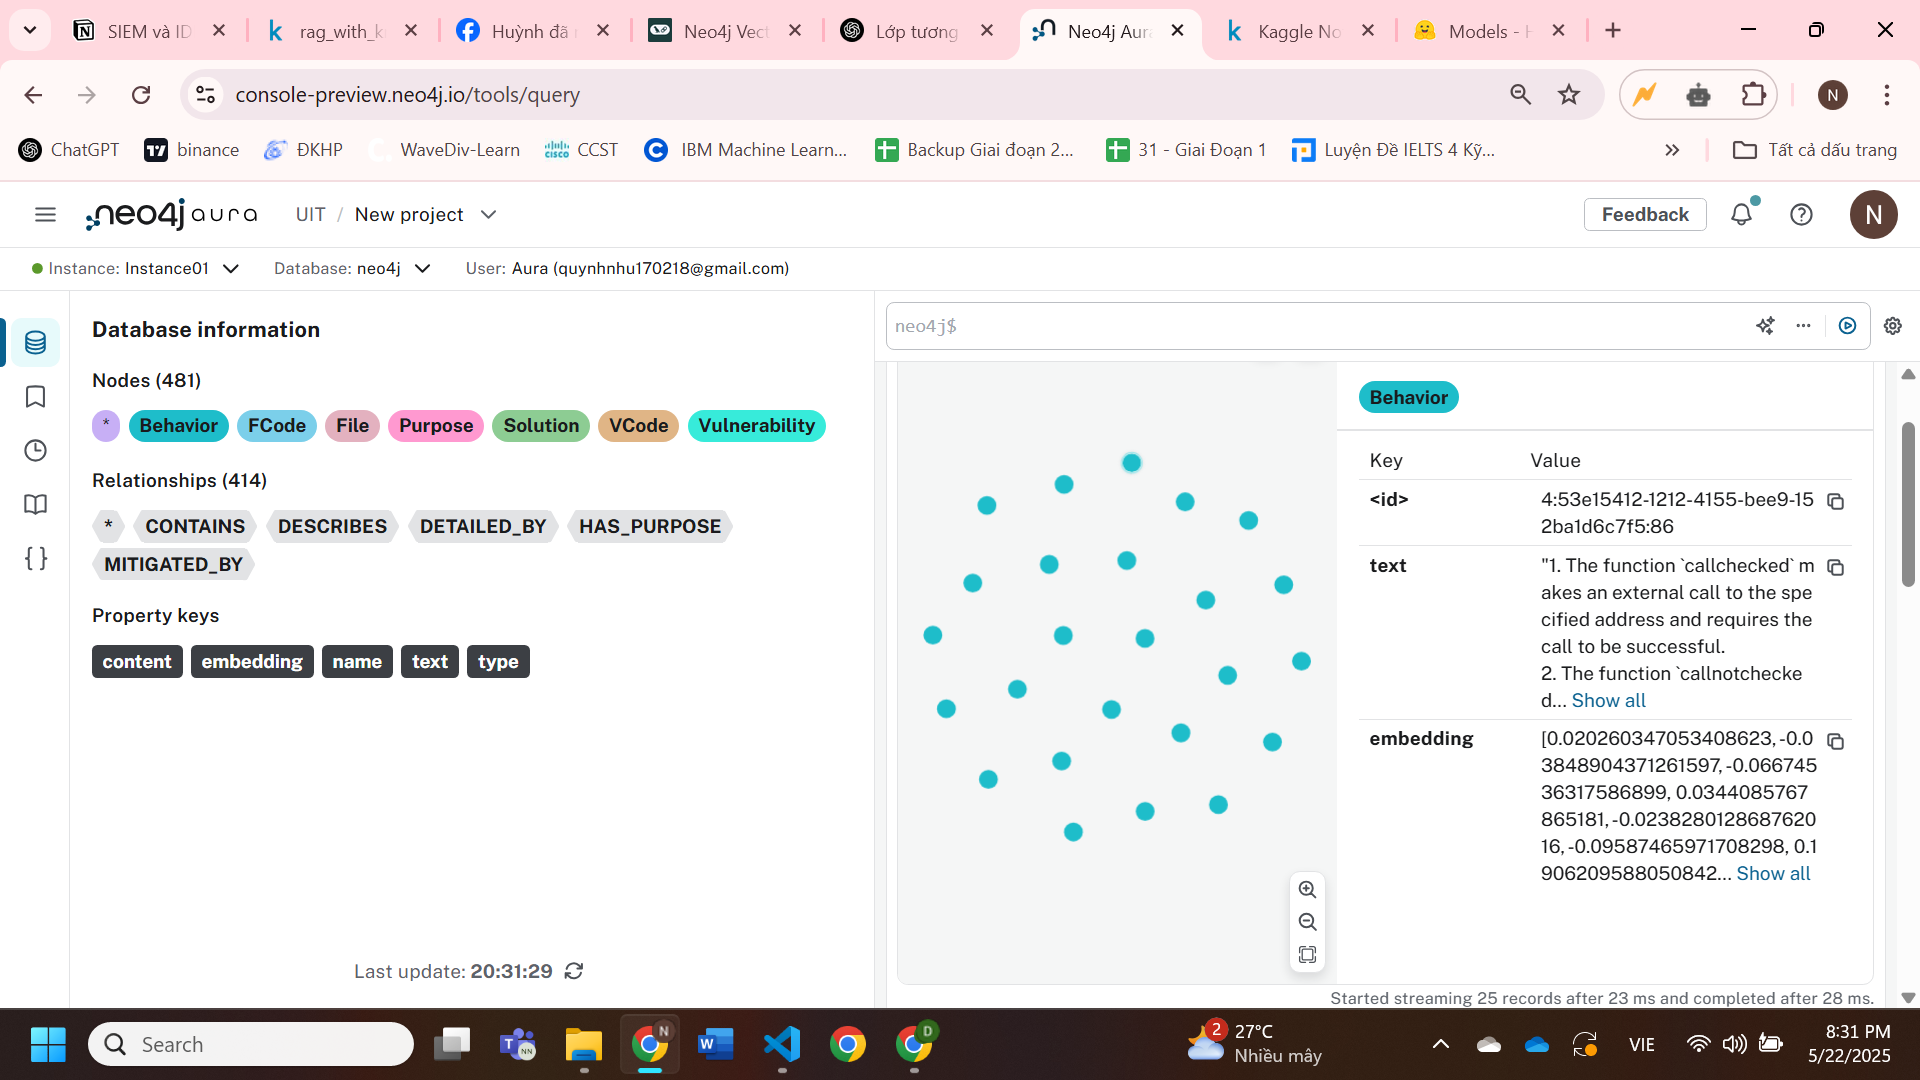

### initialize instance pointing to index to query

In [12]:
pur_index = Neo4jVector.from_existing_graph(
    embedding=embeddings,
    url=url,
    username=username,
    password=password,
    index_name="Purpose_index",
    node_label="Purpose",
    text_node_properties=["text"],
    embedding_node_property="embedding"
)

vuln_index = Neo4jVector.from_existing_graph(
    embedding=embeddings,
    url=url,
    username=username,
    password=password,
    index_name="vulnerability_index",
    node_label="Vulnerability",
    text_node_properties=["text"],
    embedding_node_property="embedding"
)

giờ tôi muốn là thêm 1 relationship giữ node purpose và node vulnerability được k, rồi từ user input, lấy nó đi similarity search với purpose, từ purpose đó cho ra csac vulnerability có relationship liên quan tới purpose đó

MATCH (p:Purpose), (v:Vulnerability)

MERGE (p)-[:RELATED_TO]->(v)

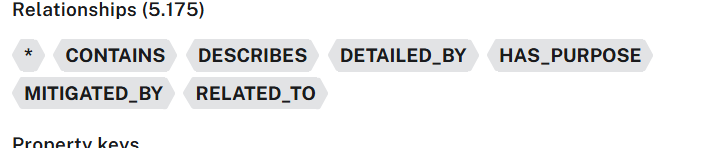

In [15]:
from neo4j import GraphDatabase

driver = GraphDatabase.driver(url, auth=(username, password))

In [13]:
# 1. Nhận input từ user
user_query = "integer overflow"
# 2. Tìm Purpose gần nhất với input
docs_with_score = pur_index.similarity_search_with_score(user_query, k=2)
for doc, score in docs_with_score:
    print("Score: ", score)
    print(doc.page_content)
    print("-" * 80)

Score:  0.8040716648101807

text: The code snippet demonstrates a smart contract that is vulnerable to integer overflow attacks.
--------------------------------------------------------------------------------
Score:  0.786191463470459

text: This smart contract demonstrates multiple transactions and functions with integer overflow susceptibility.
--------------------------------------------------------------------------------


In [16]:
def truncate_to_tokens(text, max_tokens=100):
    tokens = text.split()
    if len(tokens) <= max_tokens:
        return text
    return ' '.join(tokens[:max_tokens]) + ' ...'


def clean_text(raw_text):
    """Loại bỏ prefix text: nếu có"""
    clean = raw_text.strip()
    if clean.lower().startswith("text:"):
        clean = clean[5:].strip()
    return clean

def get_related_vulnerabilities(tx, purpose_text):
    query = """
    MATCH (p:Purpose)-[:RELATED_TO]->(v:Vulnerability)
    WHERE p.text = $purpose_text
    RETURN v.text AS vuln_text
    """
    return tx.run(query, purpose_text=purpose_text).data()

all_related_vulns = []

with driver.session() as session:
    for doc, score in docs_with_score:
        purpose_text = clean_text(doc.page_content)
        related_vulns = session.execute_read(get_related_vulnerabilities, purpose_text)
        all_related_vulns.extend(related_vulns)

# 2. In kết quả
if all_related_vulns:
    for record in all_related_vulns:
        print("==========POTENTIAL VULNERABILITY===========")
        truncated_text = truncate_to_tokens(record['vuln_text'], max_tokens=100)
        print("-", truncated_text)
else:
    print("Không có vulnerability nào liên quan.")

==========POTENTIAL VULNERABILITY===========
- The vulnerability consists of improper handling of arithmetic operations on unsigned integers, leading to a potential wrap-around effect. This is due to the absence of validation checks on input values, which allows them to surpass boundaries during arithmetic operations, thereby causing integer underflows. Such conditions can result in incorrect logic flow or malicious exploitation when large unintended values are assigned. Trigger Action: The vulnerability is triggered when an arithmetic operation, specifically subtraction, is performed without proper validation of input values, leading to an integer underflow when the value to be subtracted exceeds the operand. Detailed Vulnerability Description: The code snippet ...
==========POTENTIAL VULNERABILITY===========
- An arithmetic operation vulnerability exists when subtraction operations are performed without bounds checking, which can lead to unintended wrap-around values due to underflow

# load LLMs 